In [149]:
import requests
import joblib
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas import option_context
from tqdm import tqdm
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mannwhitneyu,shapiro,ttest_ind

import cliffsDelta as cd
import GenerateActivities as gat
import important_features as imf
from sklearn.metrics import cohen_kappa_score


In [ ]:
QUERY_ROOT = "https://api.github.com"
TOKEN = "" # write your GitHub API key here
HEADERS={'Authorization':'token '+TOKEN}

## Section 3

### Question 1

#### Write an automated Python script to identify all GitHub bot actors in the list of contributors, by querying the GitHub REST API users endpoint and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is a bot actor, if it is "User", then it is an account.

In [151]:
# 1. Read the given <sample>.csv file into a pandas DataFrame (df).
# 2. Make sure there are 2 columns, one column name is "contributor" that has the name of the contributor, 
#    and another column name is "bothunter_type" that you will use later on in this assignment.
# 3. Display the DataFrame.

# YOUR CODE BELOW

df = pd.read_csv('Contributors/sample29.csv')
display(df)  

,contributor,bothunter_type
0,Davide-sd,Human
1,Knights-Templars,Human
2,Pranavchiku,Human
3,TahiriNadia,Human
4,afgane,Human
5,allcontributors[bot],Bot
6,arjxn-py,Human
7,bjodah,Human
8,chriselrod,Human
9,codecov[bot],Bot


In [152]:
# 1. Store the names of the contributors in a list
nameList= df.loc[:,"contributor"]
# 2. print the list
display(nameList)
# YOUR CODE BELOW

0                   Davide-sd
1            Knights-Templars
2                 Pranavchiku
3                 TahiriNadia
4                      afgane
5        allcontributors[bot]
6                    arjxn-py
7                      bjodah
8                  chriselrod
9                codecov[bot]
10           codspeed-hq[bot]
11                      dbast
12            dependabot[bot]
13                 eunos-1128
14    github-merge-queue[bot]
15                  greglucas
16                imagesc-bot
17                 isabela-pf
18                    jhamman
19                   junghans
20                    ksunden
21                mahfuz05062
22                   mdsumner
23            meeseeksmachine
24                   msdemlei
25                nanosoldier
26               netlify[bot]
27                     oameye
28                 pangeo-bot
29                   petscbot
30                   philipc2
31         pre-commit-ci[bot]
32                   rjzamora
33        

In [153]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    and 'contributor' is each individual contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over each JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is a bot actor, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is a bot actor (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'actor': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app

# YOUR CODE BELOW
repList=[]
app_dict=[]
for contributor in nameList:
    query=f'{QUERY_ROOT}/users/{contributor}'
    response = requests.get(query, headers=HEADERS)
    son_response = response.json()
    repList.append(son_response)

for rep in repList:
    app_dict.append({"contributor": rep["login"], "actor":rep["type"]!="User"})

dataFrame = pd.DataFrame.from_dict(app_dict)
display(dataFrame)

,contributor,actor
0,Davide-sd,False
1,Knights-Templars,False
2,Pranavchiku,False
3,TahiriNadia,False
4,afgane,False
5,allcontributors[bot],True
6,arjxn-py,False
7,bjodah,False
8,chriselrod,False
9,codecov[bot],True


### Question 2

#### Add a new 'actor' column in the CSV file to store this information. You can write True if it is a bot actor and False if it is not.

#### Report on the total number of GitHub bot actors, and User accounts present in the list of accounts of your dataset.

In [154]:
# Merge the actor DataFrame to df by writing 'pd.merge(df, <actor df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter_type and user_type.

# YOUR CODE BELOW
test= pd.merge(df,dataFrame, on='contributor')

display(test)

,contributor,bothunter_type,actor
0,Davide-sd,Human,False
1,Knights-Templars,Human,False
2,Pranavchiku,Human,False
3,TahiriNadia,Human,False
4,afgane,Human,False
5,allcontributors[bot],Bot,True
6,arjxn-py,Human,False
7,bjodah,Human,False
8,chriselrod,Human,False
9,codecov[bot],Bot,True


### Question 3

#### For each bot actor, write their purpose, the task that they automate by looking at their GitHub profile, homepage, information on the GitHub Marketplace, or other documentation that you can find online.
# GitHub Bot Account Evidence

- **allcontributors[bot]**
  - The profile description explicitly mentions that this account is used to manage contribution acknowledgments automatically

- **codecov[bot]**
  - The account’s profile shows it is connected to Codecov, providing automated code coverage reports on pull requests.

- **codspeed-hq[bot]**
  - The profile has automated status messages and integration details that indicate it is used to manage routine tasks.

- **dependabot[bot]**
  - The profile clearly states that this account is responsible for automatically managing dependency updates.

- **github-merge-queue[bot]**
  - The account’s description indicates it handles merge queues automatically.

- **imagesc-bot**
  - i found no evidence that they are or are not bots

- **meeseeksmachine**
  - i found no evidence that they are or are not bots

- **netlify[bot]**
  - The profile shows integration with Netlify services, automating deployment-related tasks, which is a bot task.

- **pangeo-bot**
  - i found no evidence that they are or are not bots

- **petscbot**
  - i found no evidence that they are or are not bots

- **pre-commit-ci[bot]**
  - The profile clearly describes this account as handling automated checks for pre-commit hooks.

- **scverse-bot**
  - i found no evidence that they are or are not bots

- **spyder-bot**
  - i found no evidence that they are or are not bots

## Section 4

### Question 1

#### Write an automated script to use BIMBAS (Bot Identification Model Based on Activity Sequences) to obtain a prediction of the GitHub contributor type (Bot or Human) for the contributors present in your dataset.

#### Folow the steps given in each cell to use BIMBAS and obtain predictions.

### Read all the events and select the events performed by the contributors present in the given set

In [155]:
# 1. Read the csv file of events (all_events.csv) provided along with this notebook
# 2. Convert created_at column to datetime format 
#    One possible way is to use lambda function: "events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))"
# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1. 
#    e.g., ['contributor1', 'contributor2', 'contributor3',...]
# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
# 5. Display the considered events.

# YOUR CODE BELOW

# 1. Read the csv file of events (all_events.csv) provided along with this notebook
events = pd.read_csv('all_events.csv')

# 2. Convert created_at column to datetime format
events['created_at'] = pd.to_datetime(events['created_at'], unit='ms')

# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1.
contributors_list = nameList.tolist()

# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
filtered_events = events.query('login in @contributors_list')

# 5. Display the considered events.
display(filtered_events)


,Unnamed: 0,event_id,event_type,login,repository,created_at,action,PR_number,state,PR_node_id,...,comment_node_id,merged,ref,ref_type,issue_number,issue_node_id,issue_closed_at,tag_name,release_node_id,org
3,3,39747379822,IssueCommentEvent,codecov[bot],napari/napari,2024-07-01 00:00:10,created,7043.0,open,PR_kwDOCJ0aI85z_6lX,...,IC_kwDOCJ0aI86DDzXh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
64,64,39747593861,IssueCommentEvent,netlify[bot],QuantEcon/lecture-python-intro,2024-07-01 00:20:10,created,493.0,open,PR_kwDOIy5DFs50AAal,...,IC_kwDOIy5DFs6DD2NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
163,163,39747766396,CreateEvent,dependabot[bot],SciML/EasyModelAnalysis.jl,2024-07-01 00:34:53,NaN,NaN,NaN,NaN,...,NaN,NaN,dependabot/github_actions/actions/add-to-proje...,branch,NaN,NaN,NaN,NaN,NaN,SciML
164,164,39747766717,PullRequestEvent,dependabot[bot],SciML/EasyModelAnalysis.jl,2024-07-01 00:34:55,opened,261.0,open,PR_kwDOI1YYHs50AC5Y,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SciML
398,398,39749355018,CreateEvent,dependabot[bot],pymc-devs/pymc,2024-07-01 02:26:02,NaN,NaN,NaN,NaN,...,NaN,NaN,dependabot/github_actions/docker/build-push-ac...,branch,NaN,NaN,NaN,NaN,NaN,pymc-devs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358441,358441,42415794095,PushEvent,ksunden,matplotlib/matplotlib,2024-09-30 23:55:15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,matplotlib
358442,358442,42415793993,PullRequestEvent,ksunden,matplotlib/matplotlib,2024-09-30 23:55:15,closed,28584.0,closed,PR_kwDOABUios51opwG,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,matplotlib
358443,358443,42415794156,IssuesEvent,ksunden,matplotlib/matplotlib,2024-09-30 23:55:16,closed,NaN,closed,NaN,...,NaN,NaN,NaN,NaN,27971.0,I_kwDOABUios6DYpCk,2024-09-30T23:55:15Z,NaN,NaN,matplotlib
358444,358444,42415794181,IssuesEvent,ksunden,matplotlib/matplotlib,2024-09-30 23:55:16,closed,NaN,closed,NaN,...,NaN,NaN,NaN,NaN,27971.0,I_kwDOABUios6DYpCk,2024-09-30T23:55:15Z,NaN,NaN,matplotlib


### Execute BIMBAS to obtain the predictions

In [156]:
# Do not modify this cell
# Use the following function the code below to obtain your predictions

def execute_bimbas(contributors_list, selected_events):
    '''
    args: contributors_list (list) - list of contributors in the dataset provided to you
          selected_events (DataFrame) - DataFrame of events performed by the considered contributors
    return: bimbas_prediction (DataFrame) - DataFrame of preditions along with the confidence in prediction for each contributor
    '''
    result=pd.DataFrame()
    temp_list = []
    bimbas = joblib.load('bimbas.joblib')
    date_limit = pd.to_datetime(selected_events.created_at.max()) + pd.DateOffset(-90)
    
    for contributor in tqdm(contributors_list):
        # c = contributors[contributor]
        activities = gat.activity_identification(selected_events.query('login==@contributor and created_at>=@date_limit'))
        activity_features = (
                            imf.extract_features(activities)
                            .set_index([[contributor]])
                            )
        # features = pd.concat([features,activity_features])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            probability = bimbas.predict_proba(activity_features)[0][1]
        if(probability <= 0.5):
            contributor_type = 'Human'
        else:
            contributor_type = 'Bot'
        confidence = (abs(probability - 0.5)*2).round(3)
    
        pred = activity_features.set_index([[contributor]]).assign(
            prediction=contributor_type,
            confidence = confidence,
            )
        temp_list.extend([{'contributor':contributor,'bimbas_type':contributor_type,'confidence':confidence}])
    
    bimbas_prediction = pd.DataFrame.from_dict(temp_list)

    return(bimbas_prediction)

In [157]:
# Write your code here to call execute_bimbas function. 
# Pass the contributors list and the filtered events DataFrame as argument to "execute_bimbas" function
# Prediction returned by BIMBAS will have "contributor", "bimbas_type" and "confidence"
# Note: Print the prediction provided by BIMBAS - else this cell will not be graded.

# YOUR CODE BELOW

bimbas_prediction = execute_bimbas(contributors_list, filtered_events)
print(bimbas_prediction)

100%|██████████| 40/40 [00:13<00:00,  2.93it/s]

                contributor bimbas_type  confidence
0                 Davide-sd       Human       0.764
1          Knights-Templars       Human       0.741
2               Pranavchiku       Human       0.910
3               TahiriNadia         Bot       0.837
4                    afgane       Human       0.708
5      allcontributors[bot]         Bot       0.567
6                  arjxn-py       Human       0.919
7                    bjodah       Human       0.858
8                chriselrod       Human       0.895
9              codecov[bot]         Bot       0.938
10         codspeed-hq[bot]         Bot       0.916
11                    dbast       Human       0.734
12          dependabot[bot]         Bot       0.834
13               eunos-1128       Human       0.899
14  github-merge-queue[bot]         Bot       0.794
15                greglucas       Human       0.898
16              imagesc-bot       Human       0.145
17               isabela-pf       Human       0.844
18          

### Create a column in your predictions DataFrame to have predictions provided by BIMBAS. 
### Now your DataFrame should have the following columns - contributor, bothunter_type, app, bimbas_type, confidence 

### Merging bothunter and bimbas predictions

In [158]:
# Merge the predictions provided by BIMBAS to the resultant dataset of Section 3. This final DataFrame should have the following columns - 
# contributor, bothunter_type, user_type, bimbas_type, and confidence.

# YOUR CODE BELOW

final_df = pd.merge(test, bimbas_prediction, on='contributor')
display(final_df)

,contributor,bothunter_type,actor,bimbas_type,confidence
0,Davide-sd,Human,False,Human,0.764
1,Knights-Templars,Human,False,Human,0.741
2,Pranavchiku,Human,False,Human,0.910
3,TahiriNadia,Human,False,Bot,0.837
4,afgane,Human,False,Human,0.708
5,allcontributors[bot],Bot,True,Bot,0.567
6,arjxn-py,Human,False,Human,0.919
7,bjodah,Human,False,Human,0.858
8,chriselrod,Human,False,Human,0.895
9,codecov[bot],Bot,True,Bot,0.938


### Question 2
#### Using Cohen's Kappa compute and report the interrater agreement score between the labels computed by both the bot identification approaches. Mention your interpretation of Cohen's Kappa

In [159]:
# Assuming  two lists of labels from both bot identification approaches
labels_approach_1 = final_df['bothunter_type'].apply(lambda x: 1 if x == 'Bot' else 0).tolist()
labels_approach_2 = final_df['bimbas_type'].apply(lambda x: 1 if x == 'Bot' else 0).tolist()

# Compute Cohen's Kappa score
kappa_score = cohen_kappa_score(labels_approach_1, labels_approach_2)

# Report the score
print(f"Cohen's Kappa score: {kappa_score}")

# Interpretation of Cohen's Kappa
if kappa_score < 0:
    interpretation = "Less than chance agreement"
elif kappa_score <= 0.20:
    interpretation = "Slight agreement"
elif kappa_score <= 0.40:
    interpretation = "Fair agreement"
elif kappa_score <= 0.60:
    interpretation = "Moderate agreement"
elif kappa_score <= 0.80:
    interpretation = "Substantial agreement"
else:
    interpretation = "Almost perfect agreement"

print(f"Interpretation of Cohen's Kappa: {interpretation}")

Cohen's Kappa score: 0.7311827956989247
Interpretation of Cohen's Kappa: Substantial agreement


### Question 3
#### Determine the final type of each contributor. Whenever user_type column has the value "User" check if both bimbas_type and bothunter_type give the same prediction, then consider it as your final prediction in "acc_type" column.
#### For the contributors that have different predictions, i.e. bimbas_type is not same as bothunter_type, then make a manual verification and consider that as the type for that contributor. Add an extra column to the DataFrame ﬁle called 'manual' that has the label determined by you. 
#### For manual verification you can make use the GitHub UI and the GitHub API https://api.github.com/users/username

#### Whenever user_type column has the value "Bot", directly write your final acc_type as "Bot Actor"

#### More information:
For each contributor, you can look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor>/events, to make a decision on their type.

In addition, you can also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This will be useful to answer your next question.

- **TahiriNadia**: Not a bot; personalized commit messages and detailed project discussions.
- **imagesc-bot**: Unclear; So i'll say it's a bot because of it's name.
- **mahfuz05062**: Not a bot;  manual issue tracking and thoughtful code contributions ( not like changing versions or dates).
- **nanosoldier**: Not a bot; personalized pull request reviews.
- **ropensci-review-bot**: Not a bot; the name threw me off but i saw manual review comments.


In [160]:
# Write the code for your manual decision here
# example : 
# manual_list_dict = [{'contributor': '<contributor name>', 'manual': '<your prediction>'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)

# YOUR CODE BELOW
# Example manual decisions
manual_list_dict = [
    {'contributor': 'TahiriNadia', 'manual': 'Human'},
    {'contributor': 'imagesc-bot', 'manual': 'bot'},
    {'contributor': 'mahfuz05062', 'manual': 'Human'},
    {'contributor': 'nanosoldier', 'manual': 'Human'},
    {'contributor': 'ropensci-review-bot', 'manual': 'Human'},
]
# Convert the list of dictionaries to a DataFrame
manual_df = pd.DataFrame.from_dict(manual_list_dict)

# Display the DataFrame
print(manual_df)


           contributor manual
0          TahiriNadia  Human
1          imagesc-bot    bot
2          mahfuz05062  Human
3          nanosoldier  Human
4  ropensci-review-bot  Human


In [161]:
# Write your code below here to determine the final type of contributor.
# add column named 'acc_type' and write your final decision in it. Final decision is majority of three types - bimbas_type, bothunter_type, manual.
# Merge the manual_df with final_df on the 'contributor' column
merged_df = final_df.merge(manual_df, on='contributor')

# Function to determine the majority type
def majority_vote(row):
    votes = [row['bimbas_type'], row['bothunter_type'], row['manual']]
    return max(set(votes), key=votes.count)

# Apply the majority_vote function to each row and create a new column 'acc_type'
merged_df['acc_type'] = merged_df.apply(majority_vote, axis=1)

# Display the DataFrame with the new 'acc_type' column
print(merged_df)

           contributor bothunter_type  actor bimbas_type  confidence manual  \
0          TahiriNadia          Human  False         Bot       0.837  Human   
1          imagesc-bot            Bot  False       Human       0.145    bot   
2          mahfuz05062          Human  False         Bot       0.918  Human   
3          nanosoldier          Human  False         Bot       0.896  Human   
4  ropensci-review-bot          Human  False         Bot       0.842  Human   

  acc_type  
0    Human  
1      bot  
2    Human  
3    Human  
4    Human  


### Question 4
#### Study and report the purpose of these identified bots and humans in the repository assigned to you.
#### For example, the purpose can be based on but not limited to - 
##### 1) the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), 
##### 2) type of comments they are posting (reviewing code, test summary report), 
##### 3) when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on.  
#### Note: 
##### The purpose can be other than what is provided in examples above.

## Section 5

### Question 1
#### Use the filtered events file that has the events performed by the contributors provided to you
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['login','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and
5. Reset index and rename axis with None
7. Finally merge it with your 'acc_type' field from the DataFrame you created in Section4, drop contributor, and fillna with 0
8. The final DataFrame should have the following columns - login, PR, commit, issue, repo, acc_type

The final DataFrame should be looking like the following  
![](event_group.png)

In [164]:
# In the resultant DataFrame - each row should corespond to a contributor, and the columns should have all the event groups  
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contriubutor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']


In [197]:
# YOUR CODE BELOW
# Load the event data from the CSV file
events_df = pd.read_csv('all_events.csv')

merged_df = final_df.merge(manual_df, on='contributor')

# Function to determine the majority type
def majority_vote(row):
    votes = [row['bimbas_type'], row['bothunter_type'], row['manual']]
    return max(set(votes), key=votes.count)

merged_df['acc_type'] = merged_df.apply(majority_vote, axis=1)


In [198]:
# YOUR CODE BELOW# 

def count_events(group, df):
    return df[df['event_type'].isin(group)].groupby('login').size().reset_index(name=f'{group[0]}_count')

# Count events for each group
issue_counts = count_events(issue_group, events_df)
pr_counts = count_events(pr_group, events_df)
commit_counts = count_events(commit_group, events_df)
repo_counts = count_events(repo_group, events_df)

# Merge all counts into a single DataFrame
result_df = merged_df[['contributor', 'acc_type']]
result_df = result_df.merge(issue_counts.rename(columns={'login': 'contributor', 'IssueCommentEvent_count': 'issue'}), on='contributor', how='left')
result_df = result_df.merge(pr_counts.rename(columns={'login': 'contributor', 'PullRequestEvent_count': 'PR'}), on='contributor', how='left')
result_df = result_df.merge(commit_counts.rename(columns={'login': 'contributor', 'CommitCommentEvent_count': 'commit'}), on='contributor', how='left')
result_df = result_df.merge(repo_counts.rename(columns={'login': 'contributor', 'CreateEvent_count': 'repository'}), on='contributor', how='left')

# Fill NaN values with 0 (in case some contributors have no events in certain groups)
result_df.fillna(0, inplace=True)

# Rename the 'acc_type' column to 'type'
result_df.rename(columns={'acc_type': 'type'}, inplace=True)

# Display the resultant DataFrame
print(result_df)


           contributor   type  issue   PR  commit  repository
0          TahiriNadia  Human     18  0.0     0.0         0.0
1          imagesc-bot    bot     17  0.0     0.0         0.0
2          mahfuz05062  Human     47  0.0     0.0         0.0
3          nanosoldier  Human    102  0.0   107.0         0.0
4  ropensci-review-bot  Human    105  0.0     0.0         0.0


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Bot actors and Humans and write in DataFrame.

Row should correspond to type (Bot_BotActor and Human), Column should have Event group name and the values should be the median value of Bot_BotActor or Human for that particular event group. An example is given below

In [233]:
# # For example:
# medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot_app'}, 
#            {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
#            {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot_app'},
#            {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
#            {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot_app'},
#            {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
#            {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot_app'},
#            {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
# df_medians = pd.DataFrame.from_dict(medians)
# df_medians
medians = []

# Define the event groups and their corresponding column names
event_groups = {
    'issue': 'issue',
    'PR': 'PR',
    'commit': 'commit',
    'repository': 'repository'
}

# Calculate the median for each event group and type
for event_group, column_name in event_groups.items():
    for acc_type in result_df['type'].unique():
        median_value = result_df[result_df['type'] == acc_type][column_name].median()
        medians.append({'event_group': event_group, 'median': median_value, 'acc_type': acc_type})

# Convert the list of dictionaries to a DataFrame
df_medians = pd.DataFrame.from_dict(medians)

# Display the DataFrame with medians
display(df_medians)

,event_group,median,acc_type
0,issue,74.5,Human
1,issue,17.0,bot
2,PR,0.0,Human
3,PR,0.0,bot
4,commit,0.0,Human
5,commit,0.0,bot
6,repository,0.0,Human
7,repository,0.0,bot


### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [231]:
# # Main DataFrame
# medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot'}, 
#            {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
#            {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot'},
#            {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
#            {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot'},
#            {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
#            {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot'},
#            {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
# df_medians = pd.DataFrame.from_dict(medians)
# df_medians

In [241]:
# pivot the main DataFrame
plot=df_medians.pivot(index='acc_type', columns='event_group', values='median')#.reset_index().rename_axis(None,axis=1)
display(plot)

event_group,PR,commit,issue,repository
acc_type,,,,
Human,0.0,0.0,74.5,0.0
bot,0.0,0.0,17.0,0.0


<Axes: xlabel='event_group', ylabel='acc_type'>

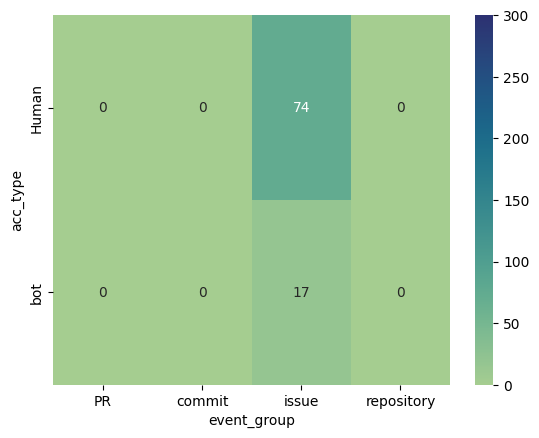

In [243]:
sns.heatmap(plot, annot=True,vmax=300,vmin=0, cmap='crest')

#### What is the difference that you observe between Bots+Bot actors and Humans?

- Bots open or interact less often with issues then humans
- There is no significan other discrepency so that can mean: 
    - only issues are a good marker of if the acount is a bot or not
    - I made mistakes in the code
    - The sample of activities provided was not a good sample

#### What is the differnce that you observe between Event groups?

- The issues event is significantly higher compared to other event groups. This indicates that both Humans and Bots actors are more actively involved in creating or commenting on issues.
- There is no significan other discrepency so that can mean: 
    - only issues are a good marker of if the acount is a bot or not
    - I made mistakes in the code
    - The sample of activities provided was not a good sample

#### What is the difference that you observe between Bots+Bot actors and Humans and Event groups all considering at the same time?

Overall, the main difference observed is that Humans are more actively involved in issue-related activities compared to Bots actors.

### Question 3

#### Create boxen plots to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot 
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

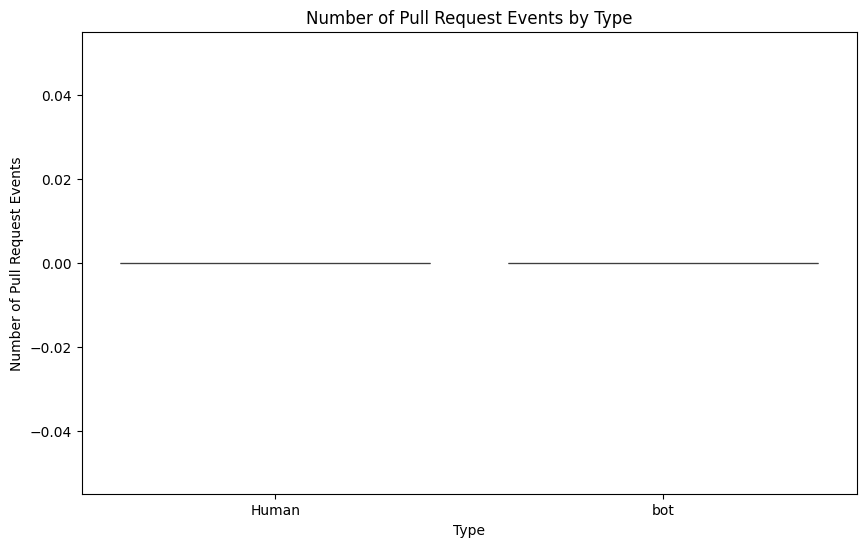

In [247]:
# YOUR CODE BELOW - Visualize number of events from pull request event group

pr_data = result_df[['contributor', 'PR', 'type']]

# Create a boxen plot for the pull request event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='type', y='PR', data=pr_data)
plt.title('Number of Pull Request Events by Type')
plt.xlabel('Type')
plt.ylabel('Number of Pull Request Events')
plt.show()


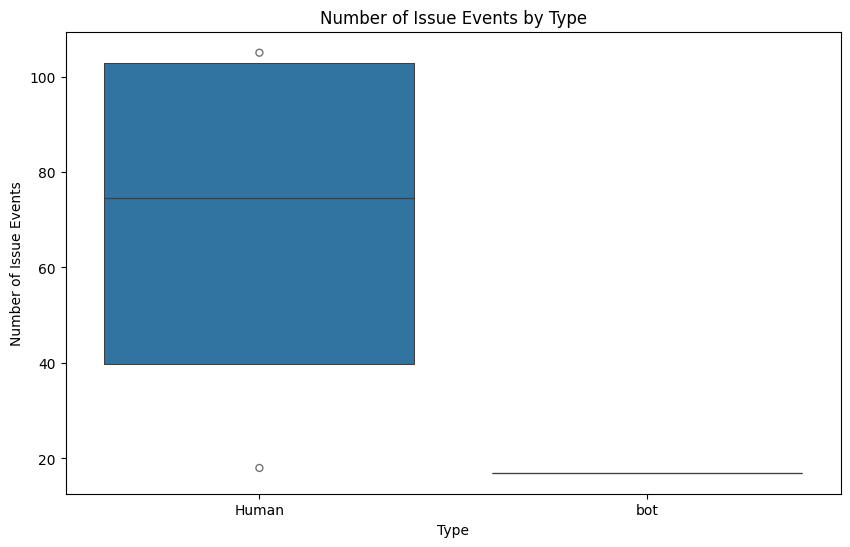

In [249]:
# YOUR CODE BELOW - Visualise number of events from issue event group
issue_data = result_df[['contributor', 'issue', 'type']]

# Create a boxen plot for the issue event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='type', y='issue', data=issue_data)
plt.title('Number of Issue Events by Type')
plt.xlabel('Type')
plt.ylabel('Number of Issue Events')
plt.show()


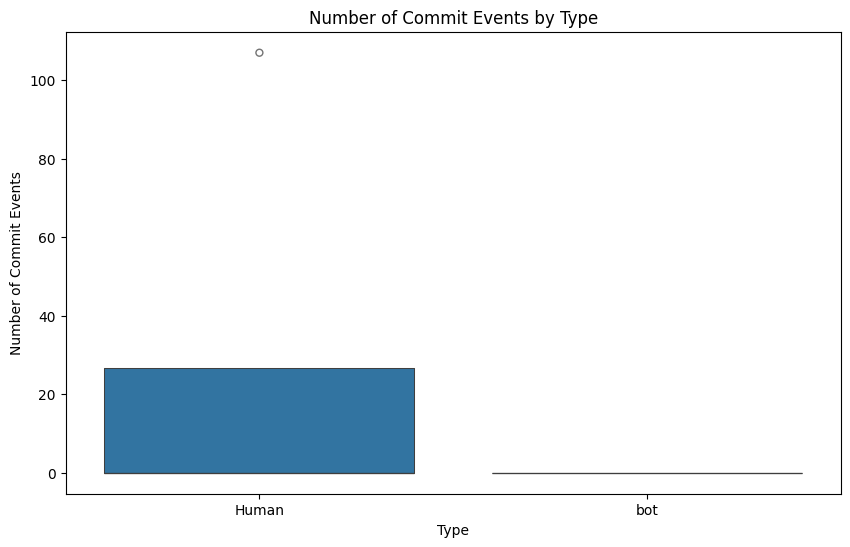

In [250]:
# YOUR CODE BELOW - Visualise number of events from commit event group

commit_data = result_df[['contributor', 'commit', 'type']]

# Create a boxen plot for the commit event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='type', y='commit', data=commit_data)
plt.title('Number of Commit Events by Type')
plt.xlabel('Type')
plt.ylabel('Number of Commit Events')
plt.show()


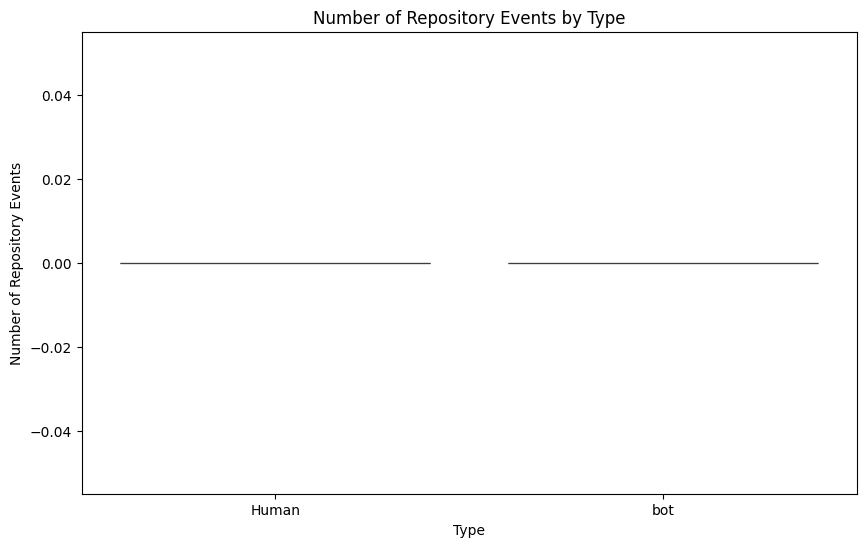

In [253]:
# YOUR CODE BELOW - Visualise number of events from repo event group
repo_data = result_df[['contributor', 'repository', 'type']]

# Create a boxen plot for the repository event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='type', y='repository', data=repo_data)
plt.title('Number of Repository Events by Type')
plt.xlabel('Type')
plt.ylabel('Number of Repository Events')
plt.show()


### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

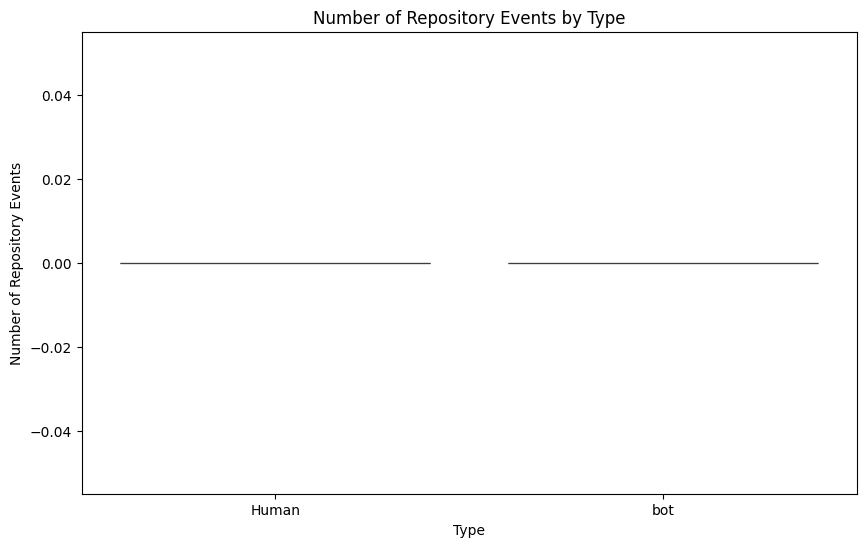

In [ ]:
# YOUR CODE BELOW


### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

In [ ]:
# YOUR CODE BELOW

### Question 4.3
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values, list of values). This will return the effect size.
#### Refer to the table given in the TP document and mention your interpretation (negligible, small, medium, large).

In [ ]:
# YOU CODE BELOW